* 测试迁移学习 baseline
* https://github.com/DavexPro/fashion-tag/blob/master/transfer_learning.ipynb 进行复盘
* 在 baseline 的基础上进行 data_augmentation

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


import itertools

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

## 导入数据

* label 文件一共有 79572 行
* 各种维度混合在一起
* 我们的目的是切分开各种维度, 进行训练和模拟
* 那么首先取出个标签的图片进行聚类

In [3]:
df_train = pd.read_csv('data-raw/train_1/Annotations/label_all.csv')
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
1,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
2,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
3,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn
4,Images/collar_design_labels/fd01ac6593f254a5dd...,collar_design_labels,ynnnn


In [4]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

## 加载数据

In [5]:
cur_class = classes[4]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

neck_design_labels: 13850


,image_id,class,label
0,Images/neck_design_labels/999a5bf5b42ab13667e0...,neck_design_labels,nynnn
1,Images/neck_design_labels/bc34bbee837d4eecdad1...,neck_design_labels,nnnyn
2,Images/neck_design_labels/08268c6d91790f2ca9ca...,neck_design_labels,nnynn
3,Images/neck_design_labels/605596277342df421156...,neck_design_labels,nnnyn
4,Images/neck_design_labels/d0ab90becdc5217aa9f7...,neck_design_labels,nnynn


In [6]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小

X = np.zeros((n, width, width, 3), dtype=np.uint8)
#X_half = np.zeros((n, 150, 150, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
prefix_cls = cur_class.split('_')[0]

In [7]:
crip_high=int(width*0.5)
crip_width_start=int(width*0.25)
crip_width_end=int(width*0.75)
for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
    if len(tmp_label) > n_class:
        print(df_load['image_id'][i])
    X[i] = cv2.resize(cv2.imread('data-raw/train_1/{0}'.format(df_load['image_id'][i])), (width, width))
    X[i] = cv2.resize(X[i][:crip_high], (width, width))
    X[i] = cv2.resize(X[i][:][:,crip_width_start:crip_width_end], (width, width))
    y[i][tmp_label.find('y')] = 1

100%|██████████| 13850/13850 [01:22<00:00, 168.13it/s]


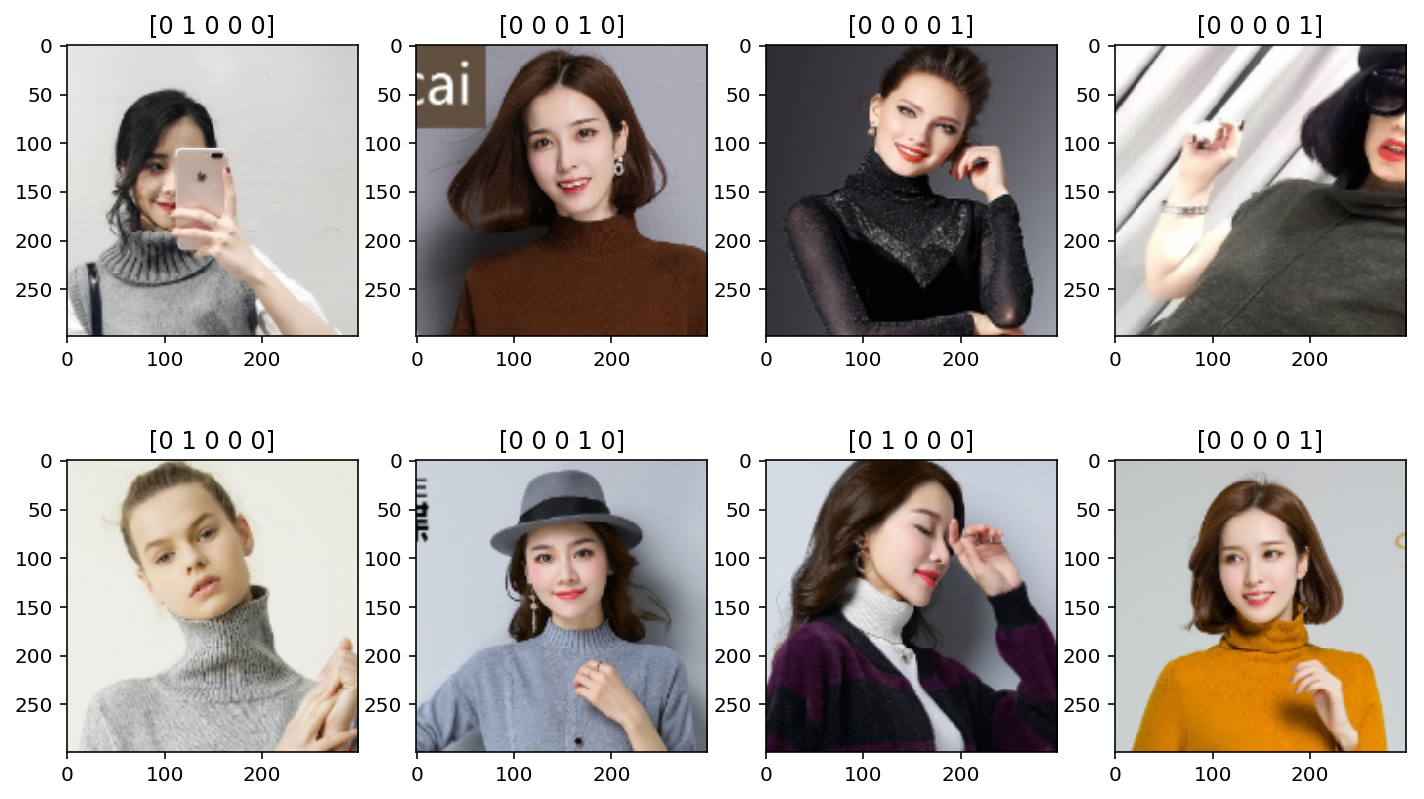

In [9]:
# 随机显示 8 张图片
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(y[random_index])

## 提取特征

In [13]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_resnet_v2 import preprocess_input
#from keras.applications.densenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
import keras

Using TensorFlow backend.


In [14]:
cnn_model =InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')

In [15]:
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

## 划分训练/测试集

In [13]:
X_train=X[:-800]
X_valid=X[-800:]
y_train=y[:-800]
y_valid=y[-800:]
X_train.shape


(13050, 299, 299, 3)

In [25]:
import gc
del X
gc.collect()

481616

In [29]:
del df_load
del df_train
gc.collect()

310418

In [20]:
x_train_path='data-raw/train_1/{}X_train_299_clip_w_h.bc'.format(prefix_cls)
x_valid_path='data-raw/train_1/{}X_valid_299_clip_w_h.bc'.format(prefix_cls)
y_train_path='data-raw/train_1/{}y_train_299_clip_w_h.bc'.format(prefix_cls)
y_valid_path='data-raw/train_1/{}y_vaild_299_clip_w_h.bc'.format(prefix_cls)

In [15]:
save_array(x_train_path,X_train)
save_array(x_valid_path,X_valid)
save_array(y_train_path,y_train)
save_array(y_valid_path,y_valid)

In [21]:
X_train=load_array(x_train_path)
X_valid=load_array(x_valid_path)
y_train=load_array(y_train_path)
y_valid=load_array(y_valid_path)

In [23]:
# Compile the model
adam = Adam(lr=1e-3)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.evaluate(x=X_valid,y=y_valid)

800/800 [==============================] - 15s 18ms/step


[0.4662819856405258, 0.85125]

In [17]:
# Set a learning rate annealer
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            #patience=3,
                                            #verbose=1,
                                            #factor=0.1,
                                            #min_lr=0.0000001)

In [19]:
epochs = 32
batch_size = 32

In [ ]:
# %%time
# prefix_cls = cur_class.split('_')[0]

# checkpointer = ModelCheckpoint(filepath='models/{0}_weights.h5'.format(prefix_cls), verbose=1, 
#                                save_best_only=True, save_weights_only=True,mode='val_acc')

# #model.load_weights('models/{0}_weights.h5'.format(prefix_cls))

# try:
#     # Fit the model
#     h = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
#               callbacks=[EarlyStopping(patience=3), checkpointer], 
#               shuffle=True, 
#                validation_data=(X_valid, y_valid))
# except KeyboardInterrupt:
#     print('KeyboardInterrupt')

Train on 5012 samples, validate on 684 samples
Epoch 1/10


## 数据增强

In [21]:
datagen = ImageDataGenerator(
        featurewise_center =False ,# set input mean to 0 over the dataset
        samplewise_center = False ,# set each sample mean to 0
        featurewise_std_normalization = False, # divide inputs by std of the dataset
        samplewise_std_normalization = False, # divide each input by its std
        zca_whitening = False, # apply ZCA whitening
        rotation_range = 20, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # randomly zoom image
        width_shift_range = 0, # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0, # randomly shift images vertivally (fraction of total heigth)
        horizontal_flip = True, # randomly flip images
        vertical_flip = False,
        shear_range = 0,
        #brightness_range=10,
        fill_mode = 'constant',
        cval = 0)


#datagen.fit(X_train,seed=123)

In [22]:
%%time
#prefix_cls = cur_class.split('_')[0]

checkpointer = ModelCheckpoint(filepath='models/{0}_alldata_clip_w_h_weights.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True, save_weights_only=True,mode='val_acc')

#model.load_weights('models/{0}_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls))

try:
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data=(X_valid, y_valid),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                                  callbacks=[EarlyStopping(patience=20), checkpointer])
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Epoch 1/32
407/407 [==============================] - 371s 911ms/step - loss: 1.0230 - acc: 0.6052 - val_loss: 0.9573 - val_acc: 0.6438

Epoch 00001: val_loss improved from inf to 0.95734, saving model to models/neck_alldata_clip_w_h_weights.h5
Epoch 2/32
407/407 [==============================] - 303s 746ms/step - loss: 0.7530 - acc: 0.7236 - val_loss: 1.0087 - val_acc: 0.6475

Epoch 00002: val_loss did not improve from 0.95734
Epoch 3/32
407/407 [==============================] - 303s 746ms/step - loss: 0.6687 - acc: 0.7532 - val_loss: 0.7341 - val_acc: 0.7388

Epoch 00003: val_loss improved from 0.95734 to 0.73410, saving model to models/neck_alldata_clip_w_h_weights.h5
Epoch 4/32
407/407 [==============================] - 303s 745ms/step - loss: 0.5953 - acc: 0.7839 - val_loss: 0.5954 - val_acc: 0.7863

Epoch 00004: val_loss improved from 0.73410 to 0.59536, saving model to models/neck_alldata_clip_w_h_weights.h5
Epoch 5/32
407/407 [==============================] - 303s 745ms/step

In [23]:
# Compile the model
adam = Adam(lr=1e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
%%time
#prefix_cls = cur_class.split('_')[0]

checkpointer = ModelCheckpoint(filepath='models/{0}2_alldata_clip_w_h_weights.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True, save_weights_only=True,mode='val_acc')

model.load_weights('models/{0}_alldata_clip_w_h_weights.h5'.format(prefix_cls))

try:
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data=(X_valid, y_valid),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                                  callbacks=[EarlyStopping(patience=20), checkpointer])
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Epoch 1/32
407/407 [==============================] - 366s 900ms/step - loss: 0.3966 - acc: 0.8576 - val_loss: 0.4884 - val_acc: 0.8300

Epoch 00001: val_loss improved from inf to 0.48844, saving model to models/neck2_alldata_clip_w_h_weights.h5
Epoch 2/32
407/407 [==============================] - 304s 748ms/step - loss: 0.3299 - acc: 0.8835 - val_loss: 0.4722 - val_acc: 0.8325

Epoch 00002: val_loss improved from 0.48844 to 0.47224, saving model to models/neck2_alldata_clip_w_h_weights.h5
Epoch 3/32
407/407 [==============================] - 305s 749ms/step - loss: 0.2848 - acc: 0.8990 - val_loss: 0.4663 - val_acc: 0.8512

Epoch 00003: val_loss improved from 0.47224 to 0.46628, saving model to models/neck2_alldata_clip_w_h_weights.h5
Epoch 4/32
407/407 [==============================] - 304s 748ms/step - loss: 0.2607 - acc: 0.9092 - val_loss: 0.5010 - val_acc: 0.8313

Epoch 00004: val_loss did not improve from 0.46628
Epoch 5/32
 47/407 [==>...........................] - ETA: 4:22 - 

In [27]:
# Compile the model
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
#prefix_cls = cur_class.split('_')[0]

checkpointer = ModelCheckpoint(filepath='models/{0}3_alldata_clip_w_h_weights.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True, save_weights_only=True,mode='val_acc')

model.load_weights('models/{0}2_alldata_clip_w_h_weights.h5'.format(prefix_cls))

try:
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data=(X_valid, y_valid),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                                  callbacks=[EarlyStopping(patience=20), checkpointer])
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Epoch 1/32
407/407 [==============================] - 367s 901ms/step - loss: 0.2390 - acc: 0.9172 - val_loss: 0.4807 - val_acc: 0.8500

Epoch 00001: val_loss improved from inf to 0.48070, saving model to models/neck3_alldata_clip_w_h_weights.h5
Epoch 2/32
278/407 [===================>..........] - ETA: 1:34 - loss: 0.2427 - acc: 0.9150

In [67]:
# Compile the model
adam = Adam(lr=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
%%time
#prefix_cls = cur_class.split('_')[0]

checkpointer = ModelCheckpoint(filepath='models/{0}4_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True, save_weights_only=True,mode='val_acc')

model.load_weights('models/{0}3_clip_w_h_resnet_all_mem_weights.h5'.format(prefix_cls))

try:
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data=(X_valid, y_valid),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                                  callbacks=[EarlyStopping(patience=20), checkpointer])
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Epoch 1/32
229/229 [==============================] - 248s 1s/step - loss: 0.3065 - acc: 0.8920 - val_loss: 0.4593 - val_acc: 0.8431

Epoch 00001: val_loss improved from inf to 0.45926, saving model to models/neck4_clip_w_h_resnet_all_mem_weights.h5
Epoch 2/32
229/229 [==============================] - 176s 769ms/step - loss: 0.3052 - acc: 0.8937 - val_loss: 0.4602 - val_acc: 0.8456

Epoch 00002: val_loss did not improve from 0.45926
Epoch 3/32
 62/229 [=======>......................] - ETA: 2:02 - loss: 0.3125 - acc: 0.8853KeyboardInterrupt
CPU times: user 15min 10s, sys: 1min 16s, total: 16min 27s
Wall time: 8min 31s


* 第一个参数是 loss, 第二个参数是 acc

## 测试模型

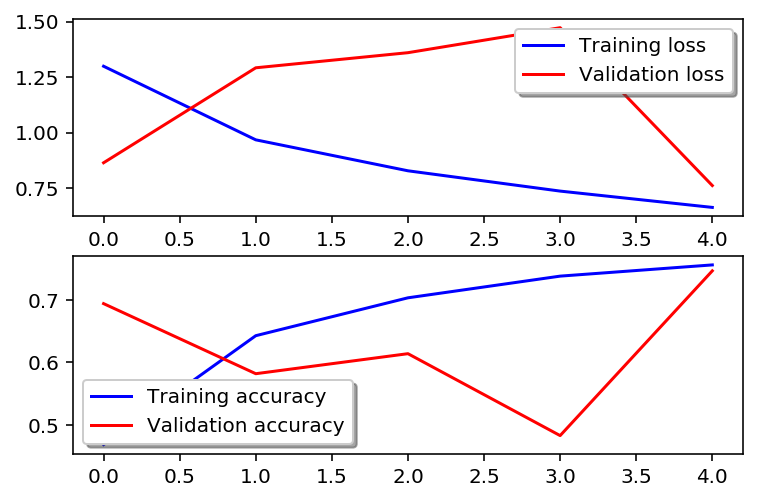

In [20]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 混淆矩阵

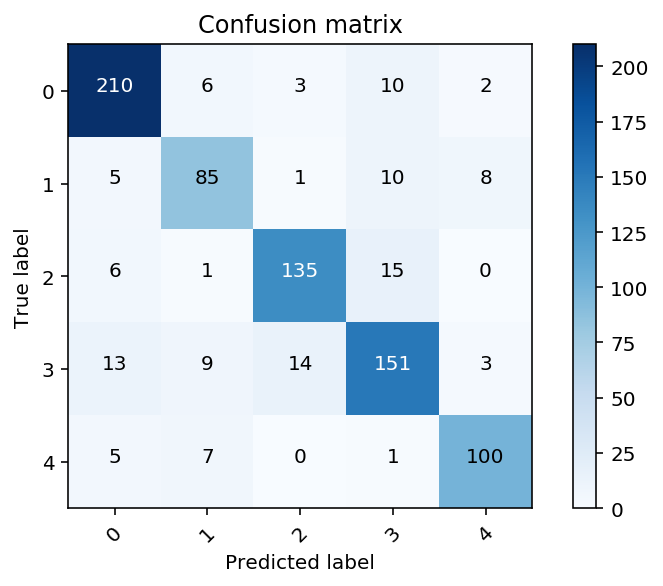

In [25]:
## Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This fuction prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plt the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(n_class))

## 误差审查

In [26]:
# Display some error results

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

In [27]:
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_valid[errors]

In [28]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((299, 299, 3)))
            ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
            n += 1

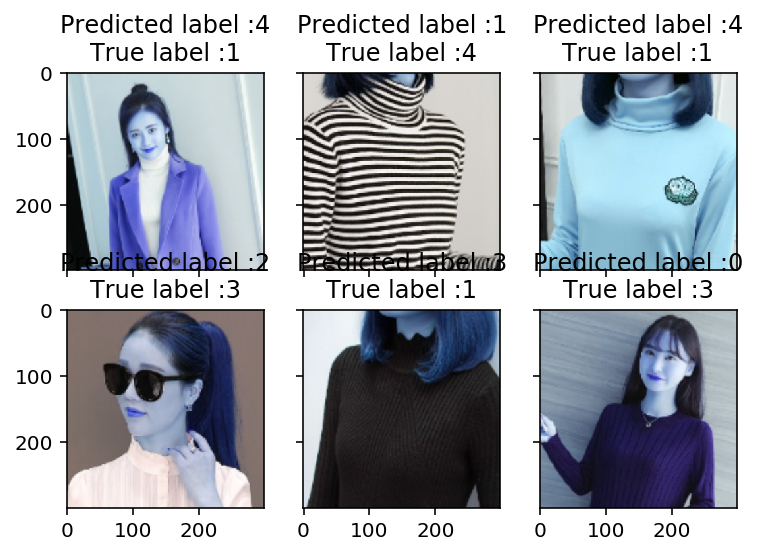

In [29]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_imaportant_errors = sorted_dela_errors[-12:]

# Show the top 6 errors
display_errors(most_imaportant_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## 加载模型

In [7]:
df_test = pd.read_csv('data-raw/week-rank/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels


In [8]:
df_load = df_test[(df_test['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

neck_design_labels: 1368


,image_id,class
0,Images/neck_design_labels/124df715c45a3f76b6e0...,neck_design_labels
1,Images/neck_design_labels/3eef78e3ecf37deb4f9f...,neck_design_labels
2,Images/neck_design_labels/e80b32f77ab355afe1ca...,neck_design_labels
3,Images/neck_design_labels/e33c717ea13b7ac83305...,neck_design_labels
4,Images/neck_design_labels/9a4313e3f13cbc121e5c...,neck_design_labels


In [11]:
n = len(df_load)

X_test = np.zeros((n, width, width, 3), dtype=np.uint8)
#X_test_hori=X_test[:]
for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('data-raw/week-rank/{0}'.format(df_load['image_id'][i])), (width, width))
    X_test[i] = cv2.resize(X_test[i][:crip_high], (width, width))
    X_test[i] = cv2.resize(X_test[i][:][:,crip_width_start:crip_width_end], (width, width))
    #X_test_hori[i]=cv2.flip(X_test[i], 1)

100%|██████████| 1368/1368 [00:08<00:00, 161.79it/s]


In [28]:
sample,rows,cols,channel = X_test.shape
Gauss_noise = np.random.normal(0, 20, (rows, cols, channel))
X_test_gauss=X_test+Gauss_noise

In [17]:
save_array('data-raw/week-rank/{}X_test.bc'.format(prefix_cls),X_test)
save_array('data-raw/week-rank/{}X_test_hori.bc'.format(prefix_cls),X_test_hori)
save_array('data-raw/week-rank/{}X_test_gauss.bc'.format(prefix_cls),X_test_gauss)

In [22]:
X_test=load_array('data-raw/week-rank/{}X_test.bc'.format(prefix_cls))
X_test_hori=load_array('data-raw/week-rank/{}X_test_hori.bc'.format(prefix_cls))
X_test_gauss=load_array('data-raw/week-rank/{}X_test_gauss.bc'.format(prefix_cls))

In [16]:
model.load_weights('models/{0}2_alldata_clip_w_h_weights.h5'.format(prefix_cls))

In [71]:
test_np_test = model.predict(X_test, batch_size=256)

In [30]:
test_np_test_hori = model.predict(X_test_hori, batch_size=256)

In [31]:
test_np_test_gauss = model.predict(X_test_gauss, batch_size=256)

In [32]:
test_np=(test_np_test+test_np_test_hori+test_np_test_gauss)/3

In [17]:
test_np = model.predict(X_test, batch_size=256)

In [30]:
test_np.shape

(708, 5)

In [18]:
result = []

for i, row in df_load.iterrows():
    tmp_list = test_np[i]
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load['result'] = result
df_load.head()

,image_id,class,result
0,Images/neck_design_labels/124df715c45a3f76b6e0...,neck_design_labels,0.0005;0.0078;0.0010;0.0092;0.9814
1,Images/neck_design_labels/3eef78e3ecf37deb4f9f...,neck_design_labels,0.0000;0.0012;0.0000;0.0000;0.9987
2,Images/neck_design_labels/e80b32f77ab355afe1ca...,neck_design_labels,0.0090;0.0003;0.9517;0.0385;0.0004
3,Images/neck_design_labels/e33c717ea13b7ac83305...,neck_design_labels,0.0000;0.0365;0.0007;0.0039;0.9589
4,Images/neck_design_labels/9a4313e3f13cbc121e5c...,neck_design_labels,0.0001;0.0000;0.0342;0.9656;0.0001


In [19]:
df_load.to_csv('result/{}_0524_85_resnet_clip_w_h.csv'.format(prefix_cls),header=None, index=False)